In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [201]:
def plot_portraits(images, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    return

In [320]:
def read_images(directory):
    file_list = os.listdir(directory)
    training_y = []
    testing_y = []
    for x in file_list:
        if int(x.split('.')[0].split('_')[1]) <= 6:
            training_y.append(x)
        else:
            testing_y.append(x)
    training_x = np.array([plt.imread(directory+'/'+image) for image in training_set], dtype=np.float64)
    testing_x=np.array([plt.imread(directory+'/'+image) for image in testing_set], dtype=np.float64)
    n_samples, h, w = training_x.shape
    training_y = np.array(training_y)
    testing_y = np.array(testing_y)
    return training_x,testing_x, training_y,testing_y

In [321]:
train_x,test_x,train_y,test_y = read_images('p2_data')

train,test = read_images('p2_data')

In [408]:
def eig_face(samples):
    # shape1 = 56, shape2 = 46
    shape1,shape2 = samples.shape[1],samples.shape[2]
    samples = samples.reshape((samples.shape[0],shape1*shape2))
    sample_mean = np.mean(samples,axis = 0)
    # get covariance matrix
    covariance = np.cov((samples - sample_mean).T)
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx].astype(np.float64)
    eigenvectors = eigenvectors.T
    eigenfaces = eigenvectors.reshape((2576,56,46)).astype(np.float64)
    return sample_mean,shape1,shape2,eigenvalues,eigenfaces

/Users/hsureggie/coding/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


(2576, 2576)


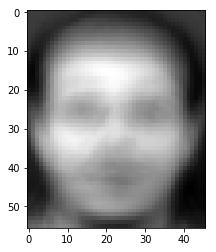

In [409]:
sample_mean,shape1,shape2,eigenvalues,eigenfaces = eig_face(train_x)
s_m = sample_mean.reshape((shape1,shape2))

# plot mean face
plt.imshow(s_m,cmap=plt.cm.gray)
print(eigenvectors.shape)


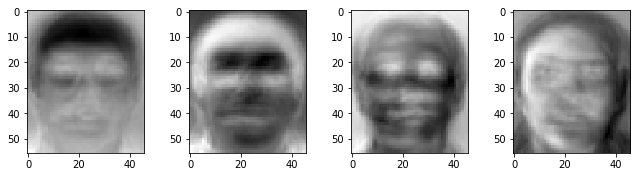

In [336]:
# plot first 4 eigenfaces

plot_portraits(eigenfaces, h=56, w=46, n_row=1, n_col=4)

In [316]:
def reconstruct(n_vectors,image_path,eigenfaces,meanface):
    h,w = 56,46
    original_image = np.array(plt.imread(image_path)).reshape((1,h*w))
    image = original_image - meanface
    recovered_images = []
    print(eigenfaces.shape)
    # image shape = (1,2576), C shape = (n_vectors[i],2576)
    for x in n_vectors:
        C = eigenfaces[:x].reshape((x,h*w))
        # weights shape = (1,n_vectors[i])
        weights = np.dot(image, C.T)
        # centered_vector shape = (1,2576)
        centered_vector=np.dot(weights, C)
        recovered_images.append((meanface+centered_vector).reshape(h, w))
    n_row,n_col = 1,4
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(recovered_images[i].reshape((h, w)), cmap=plt.cm.gray)
    return recovered_images, original_image
#     plt.imshow(recovered_image.reshape((h,w)),cmap=plt.cm.gray)

(2576, 56, 46)


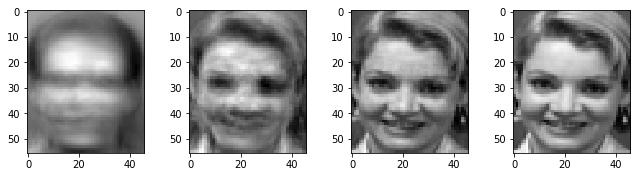

In [317]:
# given the number of eigenvectors/eigenfaces, reconstruct the image according to the vectors
recovered, original = reconstruct([3,45,140,229],'p2_data/1_1.png',eigenfaces,sample_mean)

In [318]:
def mse_image(mean_image, recovered, original):
    n_row,n_col = 2,2   
    for img in recovered:
        mse = ((img.reshape((56*46))-original)**2).mean()
        print(mse)
mse_image(sample_mean,recovered, original)

0.015490303710689273
0.004041336170058996
0.0002936813751870896
1.6859913533977837e-06


In [561]:
# find the distance between a sample and all training samples, and return the k nearest samples
def predict_class(k,training_dots_weights,temp_train_y,test_dot):
    nearest = []
    for x in range(training_dots_weights.shape[0]):
        temp_train = training_dots_weights[x]
        temp_dist = ((temp_train-test_dot)**2).sum()
        nearest.append(temp_dist)
    nearest = np.array(nearest)
    idx = nearest.argsort()
    temp_train_y = temp_train_y[idx]

    # current method: if no class is the majority, randomly pick one
    # further version: decrease k by one and vote again, repeat until a class is voted
    (values,counts) = np.unique(temp_train_y[:k],return_counts=True)
    ind=np.argmax(counts)
    voted_class = values[ind]
    return voted_class
'''
test_train = np.array([[1,2,3],[4,5,6],[7,8,9]])
test_dot = np.array([4,5,6])
temp_y = np.array([1,2,3])
predicut_class(1,test_train,temp_y,test_dot)
'''

'\ntest_train = np.array([[1,2,3],[4,5,6],[7,8,9]])\ntest_dot = np.array([4,5,6])\ntemp_y = np.array([1,2,3])\npredicut_class(1,test_train,temp_y,test_dot)\n'

In [568]:
def project_samples(meanface,n,eigenfaces,samples):
    centered_image = (samples-meanface)
    h = centered_image.shape[1]
    w = centered_image.shape[2]
    centered_image = centered_image.reshape((centered_image.shape[0],h*w))
    C = eigenfaces[:n].reshape((n,h*w))
    # shape of weights = (160,3)
    weights = np.dot(centered_image, C.T)
    return weights

In [581]:
def k_nn(k,temp_train_x,temp_train_y,temp_valid_x,temp_valid_y):
    total_samples = 0
    correct_predict = 0
    temp_train_y  = np.array(temp_train_y)
    # for each sample in validation set, find the distance to each sample in training set
    for x in range(temp_valid_x.shape[0]):
        predicted_class = predict_class(k,temp_train_x,temp_train_y,temp_valid_x[x])
#         print("predicted: ",predicted_class)
#         print("real: ",temp_valid_y[x])
        total_samples+=1
        if predicted_class.split("_")[0] == temp_valid_y[x].split("_")[0]:
            correct_predict += 1
    valid_score = correct_predict/total_samples
    return valid_score

In [571]:
# k-fold cross-validation
def three_fold_cross_validation(meanface,eigenfaces,train_x,train_y,num_sets,k,n):
    print("k: ",k," n: ",n)
    "project training samples into lowerspace and get weights"
    weights = project_samples(meanface,n,eigenfaces,train_x)
    x_sets = np.split(weights,num_sets)
    y_sets = np.split(train_y,num_sets)
    total_valid_score = 0
    # alternate the validation sets
    for x in range(len(x_sets)):
        temp_train_x = x_sets[:x]+x_sets[x+1:]
        temp_train_y = y_sets[:x]+y_sets[x+1:]
        temp_train_x = np.concatenate((temp_train_x[0],temp_train_x[1]),axis=0)
        temp_train_y = np.concatenate((temp_train_y[0],temp_train_y[1]),axis=0)
        temp_valid_x = x_sets[x]
        temp_valid_y = y_sets[x]
        valid_score = k_nn(k,temp_train_x,temp_train_y,temp_valid_x,temp_valid_y)
        total_valid_score += valid_score
        print(x+1," fold score: ",valid_score)
    average_score = total_valid_score/num_sets
    print("average_score: ",average_score)
    return average_score
# three_fold_cross_validation(s_m,eigenfaces,train_x,train_y,3,1,3)

In [572]:
k_vector = [1,3,5]
n_vector = [3,45,140]
for k in k_vector:
    for n in n_vector:
        three_fold_cross_validation(s_m,eigenfaces,train_x,train_y,3,k,n)

k:  1  n:  3
1  fold score:  0.2125
2  fold score:  0.45
3  fold score:  0.1875
average_score:  0.2833333333333333
k:  1  n:  45
1  fold score:  0.25
2  fold score:  0.75
3  fold score:  0.225
average_score:  0.4083333333333334
k:  1  n:  140
1  fold score:  0.2375
2  fold score:  0.7625
3  fold score:  0.2375
average_score:  0.41250000000000003
k:  3  n:  3
1  fold score:  0.1125
2  fold score:  0.225
3  fold score:  0.1125
average_score:  0.15
k:  3  n:  45
1  fold score:  0.1875
2  fold score:  0.4375
3  fold score:  0.1875
average_score:  0.2708333333333333
k:  3  n:  140
1  fold score:  0.1875
2  fold score:  0.4125
3  fold score:  0.175
average_score:  0.2583333333333333
k:  5  n:  3
1  fold score:  0.0625
2  fold score:  0.225
3  fold score:  0.0875
average_score:  0.125
k:  5  n:  45
1  fold score:  0.1125
2  fold score:  0.3375
3  fold score:  0.0875
average_score:  0.17916666666666667
k:  5  n:  140
1  fold score:  0.1
2  fold score:  0.3
3  fold score:  0.1
average_score:  0

In [582]:
def test(meanface,eigenfaces,train_x,train_y,test_x,test_y):
    k,n = 1,140
    train_x = project_samples(meanface,n,eigenfaces,train_x)
    test_x = project_samples(meanface,n,eigenfaces,test_x)
    test_score = k_nn(k,train_x,train_y,test_x,test_y)
    print(test_score)
test(s_m,eigenfaces,train_x,train_y,test_x,test_y)

0.9375
